# Lab 4-1: Data preprocessing. Building a regression model.

During this lab session we will train a simple regression model to predict the solubility of chemical molecules. We will use the `RDKit` library to calculate molecular descriptors from SMILES strings, and the `scikit-learn` library to implement the model. Then, we will apply some simple data preprocessing, implement a featurizer for automatic input data preparation, and wrap the whole process in a simple, user-friendly web app using `streamlit`.

---

## Loading the dataset

We will use the [AqSolDB](https://doi.org/10.1038/s41597-019-0151-1) dataset, which contains experimental solubility values for a large number of chemical molecules. The dataset is stored in the `data/aqsol.csv` file and contains the following columns:
- `Name`: the name of the molecule
- `SMILES`: the SMILES string of the molecule
- `Solubility`: logS value (base 10 logarithm of the solubility in mol/L)


In [1]:
import pandas as pd

df = pd.read_csv('data/aqsol.csv')
df.head()
y = df['Solubility']
y.head()

0   -3.616127
1   -3.254767
2   -2.177078
3   -3.924409
4   -4.662065
Name: Solubility, dtype: float64

In [2]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Crippen
from rdkit import RDLogger  
RDLogger.DisableLog('rdApp.*') # Disabling rdkit warnings

def get_descriptors(smiles_list):

    # Create a dataframe to store the descriptors (for convenience, could be done differently)
    df = pd.DataFrame({'SMILES': smiles_list})
    df['mol'] = df['SMILES'].apply(Chem.MolFromSmiles)

    # Now we can calculate the molecular descriptors themselves (I chose a few common ones here)
    df['mol_wt'] = df['mol'].apply(rdMolDescriptors.CalcExactMolWt)             # Molecular weight
    df['logp'] = df['mol'].apply(Crippen.MolLogP)                               # LogP (lipophilicity)
    df['num_heavy_atoms'] = df['mol'].apply(rdMolDescriptors.CalcNumHeavyAtoms) # Number of heavy atoms
    df['num_HBD'] = df['mol'].apply(rdMolDescriptors.CalcNumHBD)                # Number of hydrogen bond donors
    df['num_HBA'] = df['mol'].apply(rdMolDescriptors.CalcNumHBA)                # Number of hydrogen bond acceptors
    df['aromatic_rings'] = df['mol'].apply(rdMolDescriptors.CalcNumAromaticRings) # Number of aromatic rings

    # Now we select only the relevant columns (descriptors) and return the dataframe
    df = df[['mol_wt', 'logp', 'num_heavy_atoms', 'num_HBD', 'num_HBA', 'aromatic_rings']]
    return df

df = get_descriptors(df['SMILES'])
df.head()

,mol_wt,logp,num_heavy_atoms,num_HBD,num_HBA,aromatic_rings
0,391.281363,3.9581,23,0,0,0
1,169.052764,2.4055,13,1,1,2
2,140.002892,2.1525,9,0,1,1
3,754.227281,8.1161,53,2,6,6
4,422.220557,2.4854,31,0,6,2


## Calculating molecular descriptors with RDKit

**RDKit is a collection of cheminformatics tools, widely used to analyze and process chemical data.** We will use some of its functionalities to calculate molecular descriptors for the molecules in our dataset, and use the descriptors as input features for a regression model that will learn to predict the solubility of the molecules from SMILES strings. 

For this task will use only one submodule of RDKit, `rdkit.Chem.rdMolDescriptors`, which contains functions for calculating the molecular descriptors we are interested in. Feel free to explore RDKit yourself by reading [rdMolDescriptors documentation](https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html) and [RDKit documentation](https://www.rdkit.org/docs/index.html).

The most important RDKit class is `Mol` which represents a molecule with its atoms, bonds, spatial conformation, etc. Most RDKit functions, including those for calculating molecular descriptors, take a `Mol` object as input. If you have a SMILES string, you can create a `Mol` object using the `Chem.MolFromSmiles` function, as shown below:

```python
from rdkit import Chem

smiles = 'C1C(=O)NC2=C(C=C(C=C2)[N+](=O)[O-])C(=N1)C3=CC=CC=C3'
mol = Chem.MolFromSmiles(smiles)
```

From here, you can calculate various molecular descriptors that will be used as input features for our regression model. Below is an example of how to calculate some common molecular descriptors using RDKit, implemented in the `get_descriptors` function.

## Exercise 1: Split the data and extract features (1 point)

Now that we know how to calculate molecular descriptors, we can use them as input features for our regression model. Our target variable will be the `Solubility` column from the original dataset.

1. Split the dataset into a training set (80%) and a test set (20%) using the `train_test_split` function from `sklearn.model_selection`. Store the resulting dataframes as `train` and `test`.
2. Extract the molecular descriptors for both the training and test sets using the `get_descriptors` function defined above and store them in the `X_train` and `X_test` variables, respectively.
3. Store the target variable (logS values) in the `y_train` and `y_test` variables for both sets.

In [3]:
# Split the aqsol dataset into training and test sets

from sklearn.model_selection import train_test_split

X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#y_test.head()
X_test.head()

,mol_wt,logp,num_heavy_atoms,num_HBD,num_HBA,aromatic_rings
6999,238.011353,0.35030,17,3,4,1
3474,457.965226,0.70392,29,1,8,2
6128,335.072449,3.68740,23,0,3,2
7812,164.068473,-2.80540,11,5,5,0
2606,100.088815,1.62150,7,0,1,0


## Exercise 2: Test some regression models (1 points)

You already know the `scikit-learn` library, as we used it to build some classifier models in the previous labs. Now, we will use it to build a regression model. Linear regression is the simplest regression model, and it is a good starting point for regression problems. It is implemented in scikit-learn as `LinearRegression`. You should also try a more complex model, such as `SVR` (Support Vector Regression) and compare the results.

1. Train a `LinearRegression` model on the training set. Report $RMSE$ (Root Mean Squared Error) and $R^2$ score on the train and test sets.
2. Train an `SVR` model on the training set. Report $RMSE$ and $R^2$ score on the train and test sets. Use the default hyperparameters for now.

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#linear regression

lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print('Linear Regression R^2:', r2_score(y_test, y_pred_lr))
print('Linear Regression RMSE', mean_squared_error(y_test, y_pred_lr))

#SVR

svr = SVR()

svr.fit(X_train, y_train)

y_pred_svr = svr.predict(X_test)

print('SVR R^2:', r2_score(y_test, y_pred_svr))
print('SVR RMSE', mean_squared_error(y_test, y_pred_svr))




Linear Regression R^2: 0.48628596106786703
Linear Regression RMSE 2.871551671187278
SVR R^2: 0.45952023363211136
SVR RMSE 3.021166366375395


## Feature scaling - standardization and normalization

**Standardization** of datasets is a common requirement for many machine learning estimators implemented in scikit-learn. If some features of our data have very different scales (for example, one feature is in the range $[0, 1]$ and another can potentially be any positive number), some models might consider the feature with larger numerical values to be more important. This can be a problem, as we want our model to be able to learn from all features equally.

Standardization transform our data in such a way that its distribution will have a mean value $\mu = 0$ and standard deviation $\sigma = 1$. We can achieve this by using the `StandardScaler` from the `sklearn` library.

Another common preprocessing step is **normalization**. In this case, the data is scaled to a fixed range, usually $[0, 1]$. The motivation to use this scaling method includes preserving zeros in sparse data. For example, when making predictions about the expected outcome of an anticancer therapy, the value of $0$ observed tumors in a patient is probably much more informative for the predictive model than any other number of observed tumors alone. We can scale data to a certain range by using the `MinMaxScaler` from the `sklearn` library.

You can read more about those two feature scaling methods in the [Scikit-learn preprocessing docs](https://scikit-learn.org/stable/modules/preprocessing.html).

<center>
    <img src="imgs/logp-std.png" width="500">
</center>
<br>

**Remember that the scaler should be fitted only on the training set, and then used to transform both the training and test sets.** If we first transform the entire dataset and then split it into training and test sets, we are leaking the information about **test set data distribution** to the model, which would lead to overly optimistic results.

```python
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

...
```


## Exercise 3: Preprocess the input features (2 points)

1. Standardize the input features using the `StandardScaler` from `sklearn`. **Fit the scaler on the training set features and then transform both the training and test features**.
2. Train both linear regression and SVR models on the standardized training set. Report $RMSE$ and $R^2$ score on the train and test sets. How do the results compare to the previous models? Which model benefits from standardization?

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)

print('Linear Regression R^2 standardized:', r2_score(y_test, y_pred_lr))
print('Linear Regression RMSE standardized:', mean_squared_error(y_test, y_pred_lr))

#SVR

svr.fit(X_train_scaled, y_train)

y_pred_svr = svr.predict(X_test_scaled)

print('SVR R^2 standardized:', r2_score(y_test, y_pred_svr))
print('SVR RMSE standardized:', mean_squared_error(y_test, y_pred_svr))

#fit_transorm
#transform tylko transormuje 



Linear Regression R^2 standardized: 0.48628596106786537
Linear Regression RMSE standardized: 2.871551671187287
SVR R^2 standardized: 0.6593418555145936
SVR RMSE standardized: 1.9042062119502612


## Exercise 5: Make predictions on new data (1 point)

Now that we have a trained regression model, we can use it to predict the solubility of new molecules. We will use a new dataset of tryptamine derivatives for this task. The dataset is stored in the `data/tryptamines.csv` file and contains the following columns:
- `Name`: the name of the molecule
- `SMILES`: the SMILES string of the molecule
Below is some code to load the dataset and visualize the molecules.

Your task is to:
1. Extract the features using the same molecular descriptors we used before
2. Standardize them using the scaler fitted on the training set
3. Use the trained regression model (linear regression or svm) to predict the solubility of the molecules

In [6]:
import pandas as pd

tryptamines = pd.read_csv('data/tryptamines.csv')   # Load a new dataset
tryptamines.head()

,SMILES,Name
0,C1=CC=C2C(=C1)C(=CN2)CCN,Tryptamine
1,CNS(=O)(=O)CC1=CC2=C(NC=C2CCN(C)C)C=C1,Sumatriptan
2,CC(C)N(CCC1=CNC2=CC=CC=C21)C(C)C,DiPT
3,CC(=O)NCCC1=CNC2=C1C=C(C=C2)OC,Melatonin
4,NC(C)CC1=CNC2=C1C=CC=C2,AMT


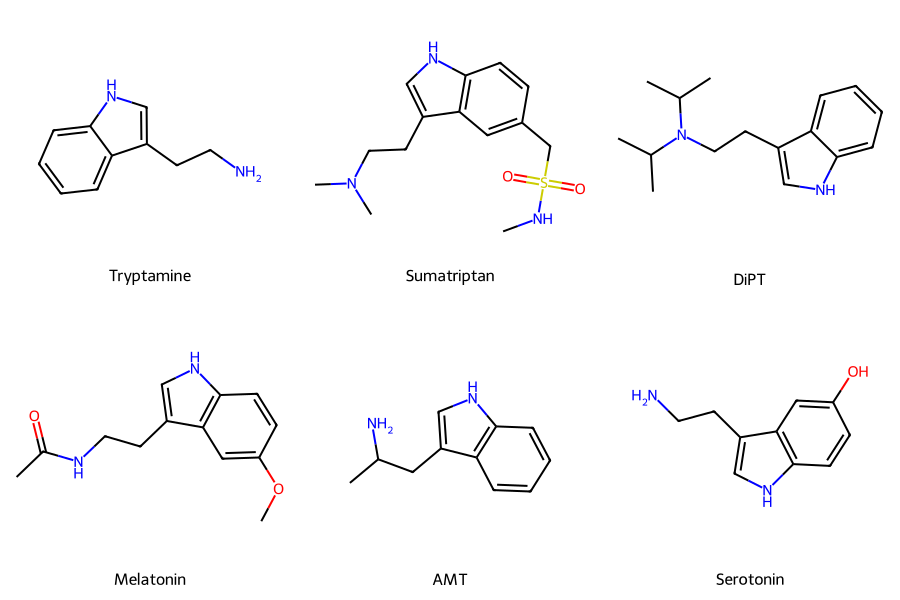

In [7]:
# Draw molecules present in the tryptamines dataset

from rdkit.Chem import Draw
from rdkit import Chem

mols = [Chem.MolFromSmiles(smiles) for smiles in tryptamines['SMILES']]
labels = tryptamines['Name'].tolist()
Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300,300), legends=labels, useSVG=True)

In [8]:
X_tryptamines = get_descriptors(tryptamines['SMILES'])

X_scaled = scaler.transform(X_tryptamines) #already fitted
y_pred = svr.predict(X_scaled)

tryptamines["Predicted_Solubility"] = y_pred

tryptamines



,SMILES,Name,Predicted_Solubility
0,C1=CC=C2C(=C1)C(=CN2)CCN,Tryptamine,-2.198390
1,CNS(=O)(=O)CC1=CC2=C(NC=C2CCN(C)C)C=C1,Sumatriptan,-2.530113
2,CC(C)N(CCC1=CNC2=CC=CC=C21)C(C)C,DiPT,-4.155327
3,CC(=O)NCCC1=CNC2=C1C=C(C=C2)OC,Melatonin,-2.684377
4,NC(C)CC1=CNC2=C1C=CC=C2,AMT,-2.450952
5,C1=CC2=C(C=C1O)C(=CN2)CCN,Serotonin,-2.510506


## Exercise 6: Featurizer class (2 points)

All the data manipulations, including the generation of features (molecular descriptors) and scaling we did completely by hand. As the project grows, this approach becomes unmanageable and error-prone. We could hide all these data preprocessing steps inside a class, so that we can reuse it easily whenever we need to extract features from a list of SMILES strings.

Let's encapsulate all the steps in a single class called `Featurizer`. 

**Featurizer is a piece of code which takes care of extracting the features and preparing them** in such a way that they can be used as an input for a ML model. In this fashion, our featurizer will be able to take a list of SMILES strings and return a dataframe with the molecular descriptors, ready to be used in any regression model.

The `Featurizer` class should implement the following methods:

1. `__init__(self, smiles_list)`

    The constructor method should:
    * Store a `StandardScaler` object as an attribute of the class.
    * Take an array of **training set** SMILES strings as input and calculate molecular descriptors for each molecule.
    * Fit the scaler to the calculated descriptors of the training set.

2. `get_descriptors(self, smiles_list)`

   This method should take an array of SMILES strings as input and return a dataframe with the molecular descriptors calculated with RDKit. You can reuse the `get_descriptors` function defined above.

3. `featurize(self, smiles_list)`
    
   This method should take an array of SMILES strings as input and return a dataframe containing molecular descriptors calculated with RDKit and scaled using the scaler fitted on the training set.

### Here is an example of how our `Featurizer` class should be used
```python
# Create an instance of the Featurizer class
featurizer = Featurizer(X_train['SMILES'])

# Say we want to predict the solubility of the following molecules
some_SMILES = ['CC(=O)Oc1ccccc1C(=O)O',     
               'C1=CC(=C(C=C1[C@H](CN)O)O)O',
               'C1=NC2=C(C(=N1)N)N=CN2C3C(C(C(O3)CO)O)O']

# Extract the features
X = featurizer.featurize(some_SMILES)

# Make predictions
y_pred = model.predict(X)
```


In [14]:
class Featurizer:
    def __init__(self, smiles_list):
        
        self.scaler = StandardScaler()
        X_train = self.get_descriptors(smiles_list)
        self.scaler.fit(X_train)
        self.feature_names = X_train.columns


    def get_descriptors(self, smiles_list):
        
        # Create a dataframe to store the descriptors (for convenience, could be done differently)
        df = pd.DataFrame({'SMILES': smiles_list})
        df['mol'] = df['SMILES'].apply(Chem.MolFromSmiles)

        # Now we can calculate the molecular descriptors themselves (I chose a few common ones here)
        df['mol_wt'] = df['mol'].apply(rdMolDescriptors.CalcExactMolWt)             # Molecular weight
        df['logp'] = df['mol'].apply(Crippen.MolLogP)                               # LogP (lipophilicity)
        df['num_heavy_atoms'] = df['mol'].apply(rdMolDescriptors.CalcNumHeavyAtoms) # Number of heavy atoms
        df['num_HBD'] = df['mol'].apply(rdMolDescriptors.CalcNumHBD)                # Number of hydrogen bond donors
        df['num_HBA'] = df['mol'].apply(rdMolDescriptors.CalcNumHBA)                # Number of hydrogen bond acceptors
        df['aromatic_rings'] = df['mol'].apply(rdMolDescriptors.CalcNumAromaticRings) # Number of aromatic rings

        # Now we select only the relevant columns (descriptors) and return the dataframe
        df = df[['mol_wt', 'logp', 'num_heavy_atoms', 'num_HBD', 'num_HBA', 'aromatic_rings']]
        return df
    
    def featurize(self, smiles_list):

        X_new = self.get_descriptors(smiles_list)
        X_new_scaled = self.scaler.transform(X_new)

        return pd.DataFrame(X_new_scaled, columns = self.feature_names)

        

In [15]:
# Test your featurizer

df_tryptamines = pd.read_csv('data/tryptamines.csv')   # Load a new dataset
df_tryptamines.head()

df_train = pd.read_csv('data/aqsol.csv')

In [16]:
featurizer = Featurizer(df_train['SMILES']) # Pass the training set SMILES strings to the constructor
X = featurizer.featurize(df_tryptamines['SMILES'])   # Extract features for the new dataset
X.head() # Take look at the generated features

,mol_wt,logp,num_heavy_atoms,num_HBD,num_HBA,aromatic_rings
0,-0.577273,-0.088477,-0.439188,0.598576,-0.710783,0.718634
1,0.156997,-0.187346,0.214323,0.598576,-0.138971,0.718634
2,-0.120003,0.525402,0.050945,-0.073013,-0.710783,0.718634
3,-0.185650,-0.035617,-0.030744,0.598576,-0.424877,0.718634
4,-0.501061,0.021931,-0.357499,0.598576,-0.710783,0.718634


In [17]:
# Predict the solubility of the new molecules

y_pred = svr.predict(X)  # Use the linear regression model to predict the solubility

tryptamines['Solubility'] = y_pred  # Add the predictions to the dataframe
tryptamines.head()

C:\Users\Piotr\anaconda\envs\pum-25\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


,SMILES,Name,Predicted_Solubility,Solubility
0,C1=CC=C2C(=C1)C(=CN2)CCN,Tryptamine,-2.198390,-2.180274
1,CNS(=O)(=O)CC1=CC2=C(NC=C2CCN(C)C)C=C1,Sumatriptan,-2.530113,-2.527777
2,CC(C)N(CCC1=CNC2=CC=CC=C21)C(C)C,DiPT,-4.155327,-4.177738
3,CC(=O)NCCC1=CNC2=C1C=C(C=C2)OC,Melatonin,-2.684377,-2.678929
4,NC(C)CC1=CNC2=C1C=CC=C2,AMT,-2.450952,-2.437365


## *Cross-validation and grid search

Now that we have a working regression model, we can try to improve its performance by tuning the hyperparameters. Last time we tuned the hyperparameters by hand, but as you may guess, that is not the most efficient way to do it. What we can (and will) do is employ a **search algorithm** to find the best hyperparameters automatically. This piece of code will try different hyperparameters and return the best combination.

Last time we introduced the concept of a **validation set**, which is a subset of the training set used to evaluate the model's performance during hyperparameter tuning. To tune the hyperparameters of a classifier model we cut out a part of the training set and used the accuracy on this validation set as a metric to evaluate the model's performance.

In practice, when tuning hyperparameters of a machine learning model, we do not usually create a single validation set. Instead, we employ a srategy called **cross-validation**. In $k$-fold cross-validation, the process of training and evaluating the model is repeated $k$ times, with each repetition using a different validation set. Thanks to this strategy, each data point present in the original training set will have the chance to be included in a validation sets. The metrics reported from $k$ folds are then averaged to get a more reliable estimate of the model's performance.

<center>
<img src="imgs/cross-validation.png" width="800">
</center>

Luckily, we do not have to implement this algorithm ourselves, as scikit-learn provides a `GridSearchCV` class that can help us with this task. It performs an exhaustive search over a specified parameter grid and evaluates the model's performance using $k$-fold cross-validation. By default, `GridSearchCV` uses a 5-fold cross-validation, which is a common choice for $k$.

In [112]:
from sklearn.model_selection import GridSearchCV

svr = SVR()

# We will define a grid of hyperparameters as a dictionary. The keys are the hyperparameter names, and the values are lists of possible values to try.

param_grid = {
    'C': [1, 5, 10, 20, 50, 100],
    'epsilon': [0.001, 0.01, 0.1, 0.5, 1]
}

grid_search = GridSearchCV(
    svr, # the model
    param_grid, # the grid of hyperparameters
    verbose=2 # print the progress
)

svr = grid_search.fit(X_train, y_train) # GridSearchCV.fit() returns the best model, and we can save it to a new variable

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END .................................C=1, epsilon=0.001; total time=   2.3s
[CV] END .................................C=1, epsilon=0.001; total time=   2.3s
[CV] END .................................C=1, epsilon=0.001; total time=   2.3s
[CV] END .................................C=1, epsilon=0.001; total time=   2.4s
[CV] END .................................C=1, epsilon=0.001; total time=   2.3s
[CV] END ..................................C=1, epsilon=0.01; total time=   2.3s
[CV] END ..................................C=1, epsilon=0.01; total time=   2.3s
[CV] END ..................................C=1, epsilon=0.01; total time=   2.3s
[CV] END ..................................C=1, epsilon=0.01; total time=   2.4s
[CV] END ..................................C=1, epsilon=0.01; total time=   2.3s
[CV] END ...................................C=1, epsilon=0.1; total time=   2.3s
[CV] END ...................................C=1

In [ ]:
from sklearn.metrics import mean_squared_error

# Report the best hyperparameters and RMSE on the testing set

print('Best hyperparameters:', svr.get_params())

y_pred = svr.predict(X_test)

print('-'*50)
print('Testing set rmse:', mean_squared_error(y_test, y_pred))

### *Randomized search

`RandomizedSearchCV` is an alternative to `GridSearchCV`. Instead of trying all possible combinations of fixed hyperparameters, it samples a fixed number of hyperparameter settings from specified probability distributions. Although you may be hesitant to use it, as it is not an exhaustive search, it is often more efficient than grid search. Randomized search is especially useful when we have many hyperparameters to tune, and we are not sure which ones are the most important. Take a look at the figure below and try to understand why this is the case.

<center>
<img src="imgs/grid-vs-random.png", width="600">
</center>

Randomized search is implemented in the same way as grid search, but with a different class. It also requires a dictionary of hyperparameters, but instead of specifying a list of values to try, we specify a **probability distribution**. See the example below:

```python
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_distributions = {
    'some_discete_hyperparameter': np.arange(1, 10), # uniform dicrete distribution from 1 to 10
    'some_continuous_hyperparameter': uniform(0, 1), # uniform continuous distribution from 0 to 1
}

random_search = RandomizedSearchCV(
    model,
    param_distributions,
    n_iter=100 # number of random samples to try
)
...
```

## Saving and loading Python objects

Both the featurizer and the trained regression model can be saved to disk as Python objects using the `pickle` module. This way, we can load them later in another script without the need to retrain the model or recalculate the molecular descriptors for fitting the feature scaler.

```python
import pickle

# Save the model

with open('path/to/model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Load the model

with open('path/to/model.pkl', 'rb') as f:
    model = pickle.load(f)

---
# Lab 4-2: Coding a simple app in Streamlit.

`sreamlit` is a Python library that allows you to create very nice-looking and user-friendly web applications with just a few lines of code. It is very easy to use and requires absolutely no knowledge of web development.

---

We should have Streamlit already installed in our environment. You probably should take a look at the [Streamlit documentation](https://docs.streamlit.io/library), but this is how you can run a simple Streamlit app:

Take look at `data/streamlit/app.py`. It is a tiny Streamlit app that takes a name as input and **returns a random fortune cookie-like quote**. Analyze the code and try to understand how it works. 

**Some important functions you may need to use:**

- `st.title` sets the title of the app
- `st.write` writes text to the app (supports [Markdown](https://www.markdownguide.org/basic-syntax/) synthax for text formatting)
- `st.dataframe` displays a dataframe
- `st.latex` renders LaTeX code (for mathematical formulas)
- `st.text_input` creates a text input field (for multiline inputs, use `st.text_area`)
- `st.button` creates a button (you can use it to trigger some action)

To run the app, open a terminal and run the following command:

    streamlit run data/streamlit/app.py
    
This will start a local server and open a new tab in your browser with the app. You can now interact with the app by entering your name and clicking the button to get a random fortune.

## Exercise 5: Build an app for solubility prediction (3 points)

This exercise is a continuation of the previous one. We will use all the code we have written so far to build a simple web app that predicts the solubility of molecules. The app will run in the browser and allow the user to input one or more SMILES strings, and will display the predicted solubility of the molecules.
The [Streamlit documentation](https://docs.streamlit.io/library) will be very helpful in this task.

**The app should have the following structure:**

1. A title and a short description of what the app does.
2. A text area where the user can input a SMILES string (or multiple SMILES strings in a column).
3. A button to submit the input.
4. A section that displays the predicted solubility of the molecule(s) as a table of SMILES strings and their corresponding solubility values.

The app should use our `Featurizer` class to extract the features from the input SMILES strings and predict the solubility using the trained `svm` regressor. **The model and the featurizer should not be trained inside the app, but loaded from a `.pkl` file instead!** Thanks to this approach, we will not need the training data to run the app, and the app will start much faster, as it will not need to retrain the model every time.

In [18]:
import pickle

with open("svr_model.pkl", "wb") as f:
    pickle.dump(svr, f)

with open("featurizer.pkl", "wb") as f:
    pickle.dump(featurizer, f)